In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import os
import cv2
import random

In [5]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [6]:
# download dataset
!kaggle datasets download -d hikmatullahmohammadi/tusimple-preprocessed
# unzip dataset
!unzip tusimple-preprocessed.zip

Streaming output truncated to the last 5000 lines.
  inflating: tusimple_preprocessed/training/frames/0313-2_37820.jpg  
  inflating: tusimple_preprocessed/training/frames/0313-2_37840.jpg  
  inflating: tusimple_preprocessed/training/frames/0313-2_37860.jpg  
  inflating: tusimple_preprocessed/training/frames/0313-2_37880.jpg  
  inflating: tusimple_preprocessed/training/frames/0313-2_37900.jpg  
  inflating: tusimple_preprocessed/training/frames/0313-2_37920.jpg  
  inflating: tusimple_preprocessed/training/frames/0313-2_37940.jpg  
  inflating: tusimple_preprocessed/training/frames/0313-2_37960.jpg  
  inflating: tusimple_preprocessed/training/frames/0313-2_37980.jpg  
  inflating: tusimple_preprocessed/training/frames/0313-2_380.jpg  
  inflating: tusimple_preprocessed/training/frames/0313-2_38000.jpg  
  inflating: tusimple_preprocessed/training/frames/0313-2_38020.jpg  
  inflating: tusimple_preprocessed/training/frames/0313-2_38040.jpg  
  inflating: tusimple_preprocessed/traini

In [7]:
strategy = tf.distribute.MirroredStrategy()
np.random.seed(42)
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH = "/content/tusimple_preprocessed/training/frames"
TRAIN_MASKS_PATH = '/content/tusimple_preprocessed/training/lane-masks'
TEST_PATH = '/content/tusimple_preprocessed/test/frames'
TEST_MASKS_PATH = '/content/tusimple_preprocessed/test/lane-masks'

train_image_files = os.listdir(TRAIN_PATH)
train_mask_files = os.listdir(TRAIN_MASKS_PATH)
test_image_files = os.listdir(TEST_PATH)
test_mask_files = os.listdir(TEST_MASKS_PATH)

X_train = np.zeros((1000, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_train = np.zeros((1000, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)

# X_train = np.zeros((len(train_image_files), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
# Y_train = np.zeros((len(train_image_files), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
# X_test = np.zeros((len(test_image_files), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)


images = []
masks = []
for n, image_file in enumerate(train_image_files):
    if os.path.splitext(image_file)[1].lower() == ".jpg" and n < 1000:
      image_path = os.path.join(TRAIN_PATH, image_file)
      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = cv2.resize(image, (256,256))
      image = image / 255

      images.append(image)

mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)
for n, mask_file in enumerate(train_mask_files):
    if os.path.splitext(mask_file)[1].lower() == ".jpg" and n < 1000:
      mask_path = os.path.join(TRAIN_MASKS_PATH, mask_file)
      mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
      mask = cv2.resize(mask, (256,256))
      mask = mask / 255.0  # Normalize to [0, 1]

      masks.append(np.expand_dims(mask, axis=-1))


X_train, Y_train = np.array(images), np.array(masks)
#print(np.min(Y_train), np.max(Y_train))

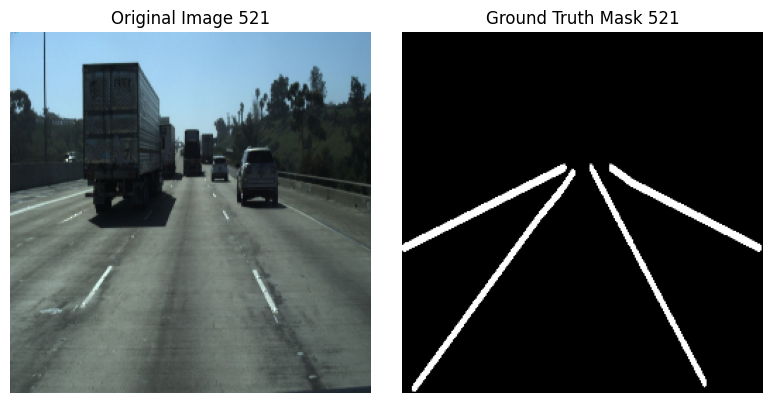

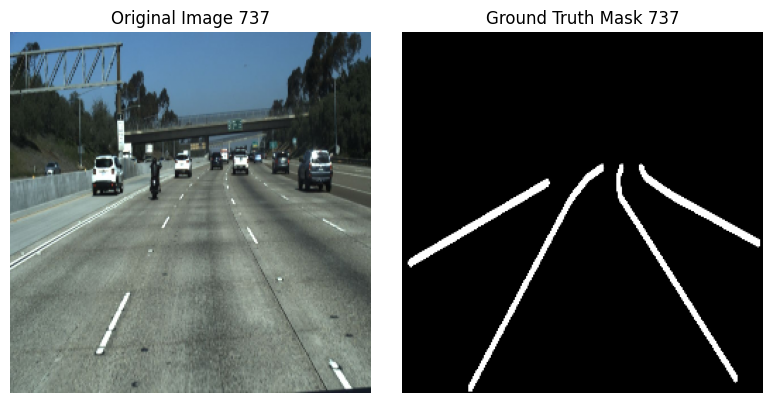

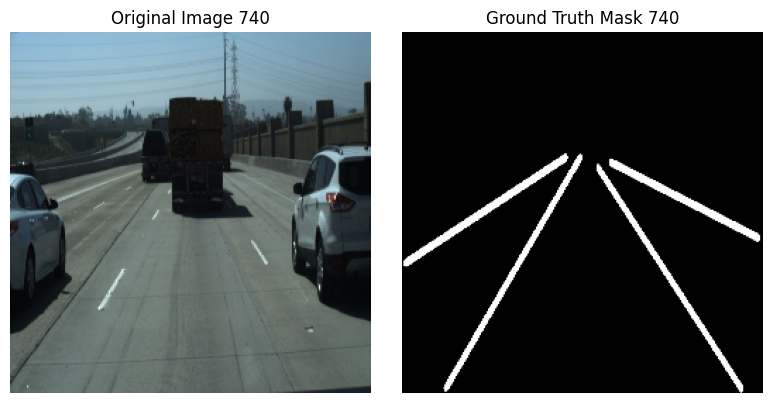

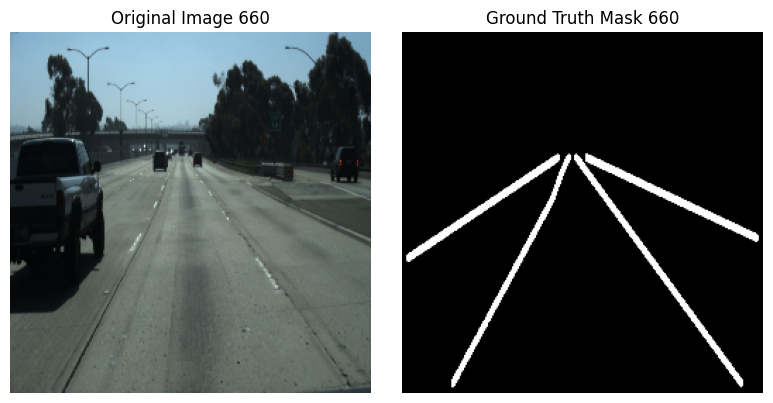

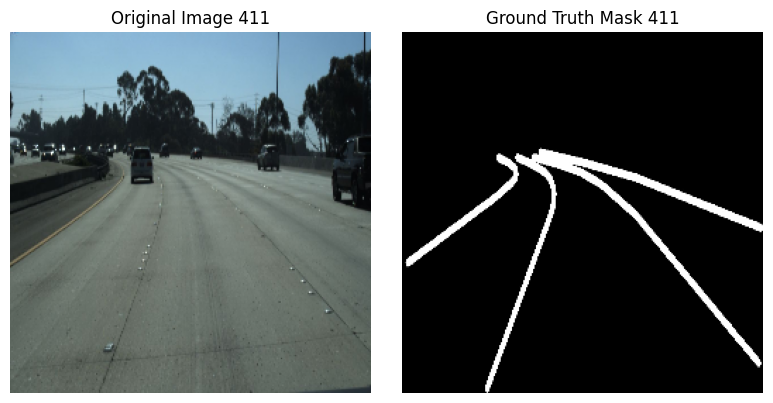

In [8]:
num_images_to_display = 5

selected_indices = np.random.choice(len(X_train), num_images_to_display, replace=False)

for i, idx in enumerate(selected_indices):
    plt.figure(figsize=(8, 4))

    # Display the original image
    plt.subplot(1, 2, 1)
    plt.imshow(X_train[idx])
    plt.title(f"Original Image {idx}")
    plt.axis('off')

    # Display the corresponding mask
    plt.subplot(1, 2, 2)
    plt.imshow(Y_train[idx].squeeze(), cmap='gray')
    plt.title(f"Ground Truth Mask {idx}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [9]:
import tensorflow as tf

def create_unet_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    inputs = tf.keras.layers.Input(input_shape)
    s = inputs

    # Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    # Bottleneck
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Expansive path
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model

def create_cascaded_unet_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    # Create the first U-Net model
    unet1 = create_unet_model(input_shape=input_shape)

    # Define the input for the cascaded U-Net
    inputs = tf.keras.layers.Input(input_shape)

    # Pass the input through the first U-Net
    unet1_output = unet1(inputs)

    # Create the second U-Net model
    unet2 = create_unet_model(input_shape=input_shape)

    # Pass the output of the first U-Net as input to the second U-Net
    cascaded_output = unet2(unet1_output)

    model = tf.keras.Model(inputs=[inputs], outputs=[cascaded_output])
    return model


In [10]:
#tf.compat.v1.disable_eager_execution()

with strategy.scope():
    model = create_unet_model()
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#print(np.min(Y_train), np.max(Y_train))
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
        tf.keras.callbacks.ModelCheckpoint('model_for_lane.keras', verbose=1, save_best_only=True)]

results = model.fit(X_train, Y_train, batch_size=16, epochs=25,steps_per_epoch=62,validation_split=0.1, callbacks=callbacks)



Epoch 1/25
57/62 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step - accuracy: 0.8900 - loss: 0.3018

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_loss improved from inf to 0.19789, saving model to model_for_lane.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 249ms/step - accuracy: 0.8934 - loss: 0.2951 - val_accuracy: 0.9455 - val_loss: 0.1979
Epoch 2/25
57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.9440 - loss: 0.1491
Epoch 2: val_loss improved from 0.19789 to 0.12827, saving model to model_for_lane.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 185ms/step - accuracy: 0.9440 - loss: 0.1486 - val_accuracy: 0.9455 - val_loss: 0.1283
Epoch 3/25
57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9447 - loss: 0.1235
Epoch 3: val_loss improved from 0.12827 to 0.10568, saving model to model_for_lane.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 185ms/step - accuracy: 0.9446 - loss: 0.1232 - val_accuracy: 0.9455 - val_loss: 0.1057
Epoch 4/25
57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.9445 - loss: 0.1049
Epoch 4: val_loss improved from 0.10568 to 0.09152, saving model to model_for_lane.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 187m

In [11]:
X_test = np.zeros((320, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_test = np.zeros((320, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
# X_test = np.zeros((len(test_image_files), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
# Y_test = np.zeros((len(test_image_files), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)

test = []
test_masks = []
for n, image_file in enumerate(test_image_files):
    if os.path.splitext(image_file)[1].lower() == ".jpg" and n < 320:
      image_path = os.path.join(TEST_PATH, image_file)
      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = cv2.resize(image, (256,256))
      image = image / 255

      test.append(image)

mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)
for n, mask_file in enumerate(test_mask_files):
    if os.path.splitext(mask_file)[1].lower() == ".jpg" and n < 320:
      mask_path = os.path.join(TEST_MASKS_PATH, mask_file)
      mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
      mask = cv2.resize(mask, (256,256))
      mask = mask / 255.0  # Normalize to [0, 1]

      test_masks.append(np.expand_dims(mask, axis=-1))

X_test, Y_test = np.array(test), np.array(test_masks)

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step


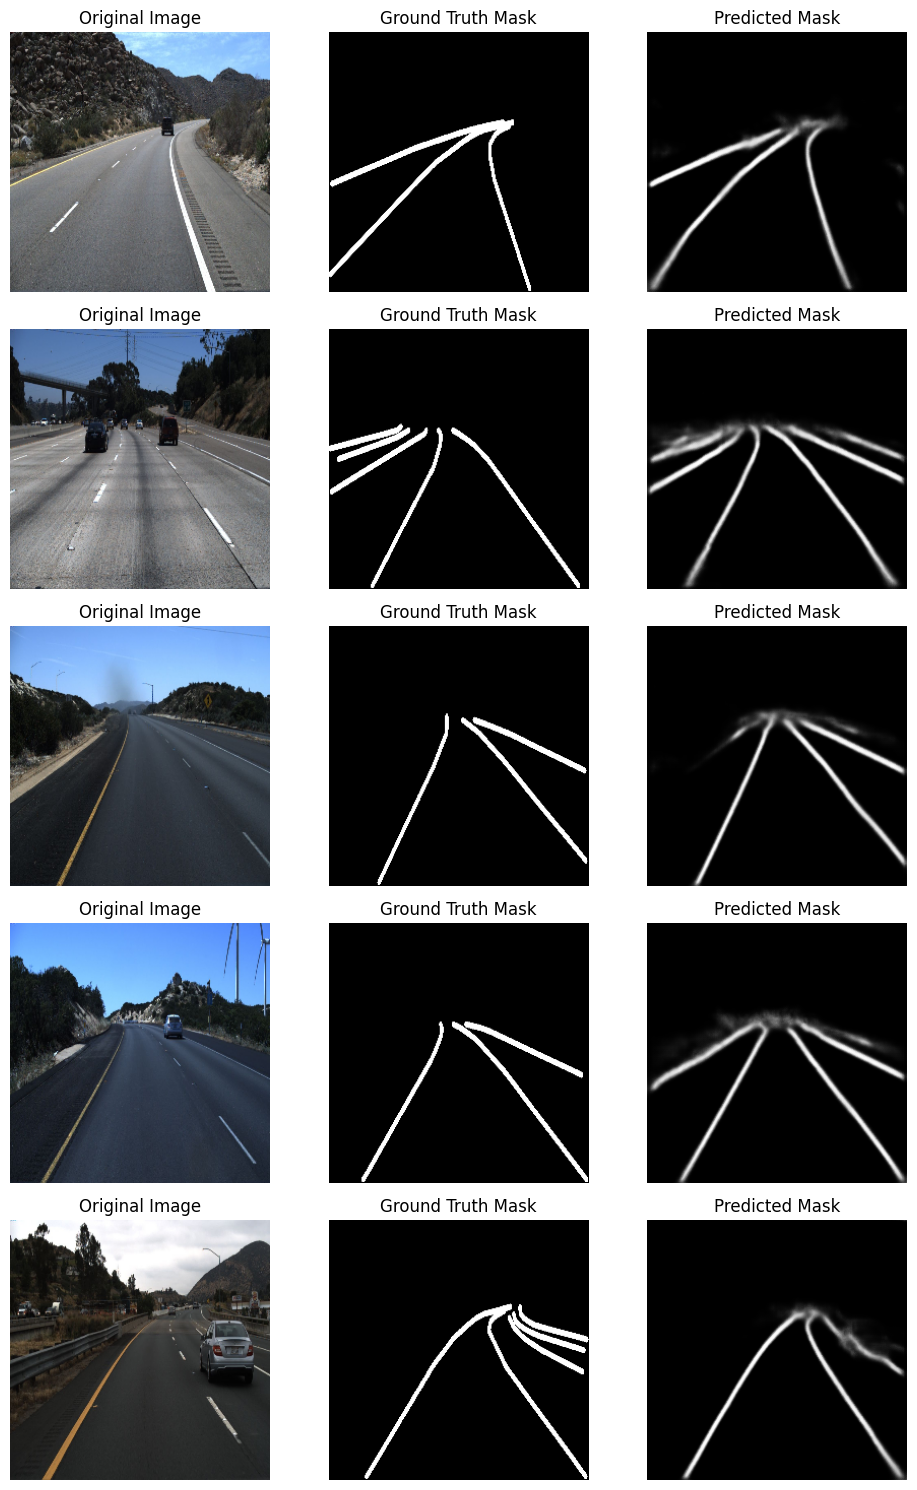

In [12]:
# trained U-Net model
model = load_model('/content/model_for_lane.keras')


y_pred = model.predict(X_test)

num_samples = 5  # Adjust the number of samples to visualize

fig, axes = plt.subplots(num_samples, 3, figsize=(10, 3*num_samples))

for i in range(num_samples):

    # original image
    axes[i, 0].imshow(X_test[i])
    axes[i, 0].set_title("Original Image")
    axes[i, 0].axis('off')

    # ground truth mask
    axes[i, 1].imshow(Y_test[i].squeeze(), cmap='gray')
    axes[i, 1].set_title("Ground Truth Mask")
    axes[i, 1].axis('off')

    # predicted mask
    axes[i, 2].imshow(y_pred[i].squeeze(), cmap='gray')
    axes[i, 2].set_title("Predicted Mask")
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

In [13]:
# Plot the validation and training curves seprately
def plot_loss_curves(history):
    """
    Returns seprate loss curves for training and validation metrics.
    """
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"])) # how many epochs did we run for?

    # Plot loss
    plt.plot(epochs,loss,label="training_loss")
    plt.plot(epochs,val_loss,label="val_loss")
    plt.title("Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs,accuracy,label="training_accuracy")
    plt.plot(epochs,val_accuracy,label="val_accuracy")
    plt.title("")
    plt.xlabel("Epochs")
    plt.title('Accuracy Curve')
    plt.ylabel("Accuracy")
    plt.legend();

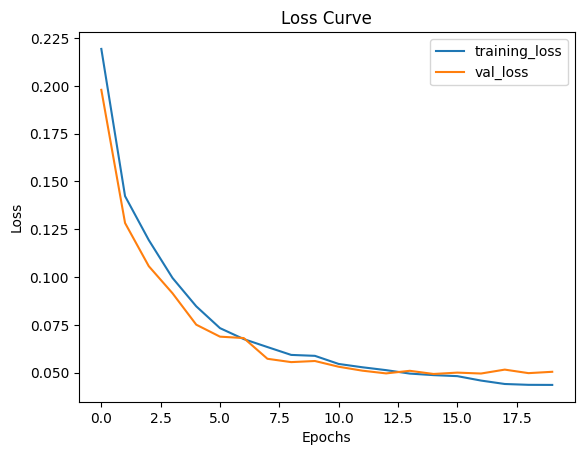

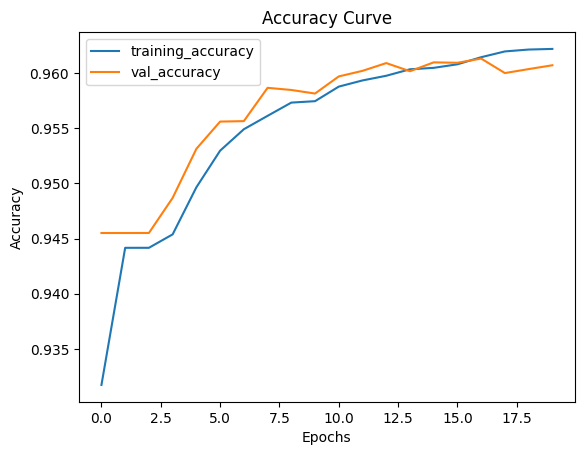

In [14]:
# Check out the loss and accuracy of model_4
plot_loss_curves(results)